In [1]:
'''
Nicole Osayande
261042925
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#investigating crystallized cognition and neighbourhood poverty occurrence
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_cryst_uncorrected','reshist_addr1_adi_pov','abcd_site','site_id_l','race_ethnicity'], index_col=False)
print(data.shape)

(10843, 5)


In [3]:
val=data['reshist_addr1_adi_pov'].median()
data.loc[data['reshist_addr1_adi_pov'] <= val, 'reshist_addr1_adi_pov_bin'] = 0
data.loc[data['reshist_addr1_adi_pov'] > val, 'reshist_addr1_adi_pov_bin'] = 1 # poverty indicator

In [4]:
data['nihtbx_cryst_uncorrected_log']= np.log(data['nihtbx_cryst_uncorrected']) #natural logarithm to fix skew-tailed data
col='nihtbx_cryst_uncorrected_log'
data['nihtbx_cryst_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0) #standardization

In [5]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [7]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
pov = data.reshist_addr1_adi_pov_bin.values
target_values = data.nihtbx_cryst_uncorrected_zscore.values

In [8]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
pov_ = shared(pov)

In [9]:
#varying intercepts and varying slopes: 
#predicting crystallized cognition scores from neighbourhood poverty occurrence

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per city, theta
    # Non-centered reparameterization 
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * pov_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 1006 seconds.
The number of effective samples is smaller than 25% for some parameters.


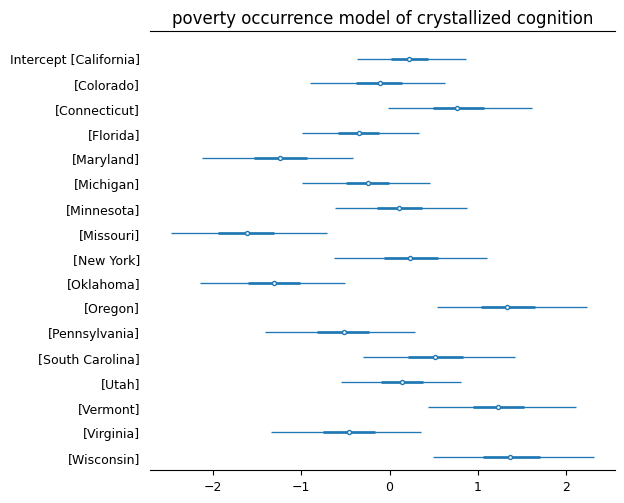

In [10]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("poverty occurrence model of crystallized cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_plot_state_intercept_pov_occur_crystallized_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63048/2159089303.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


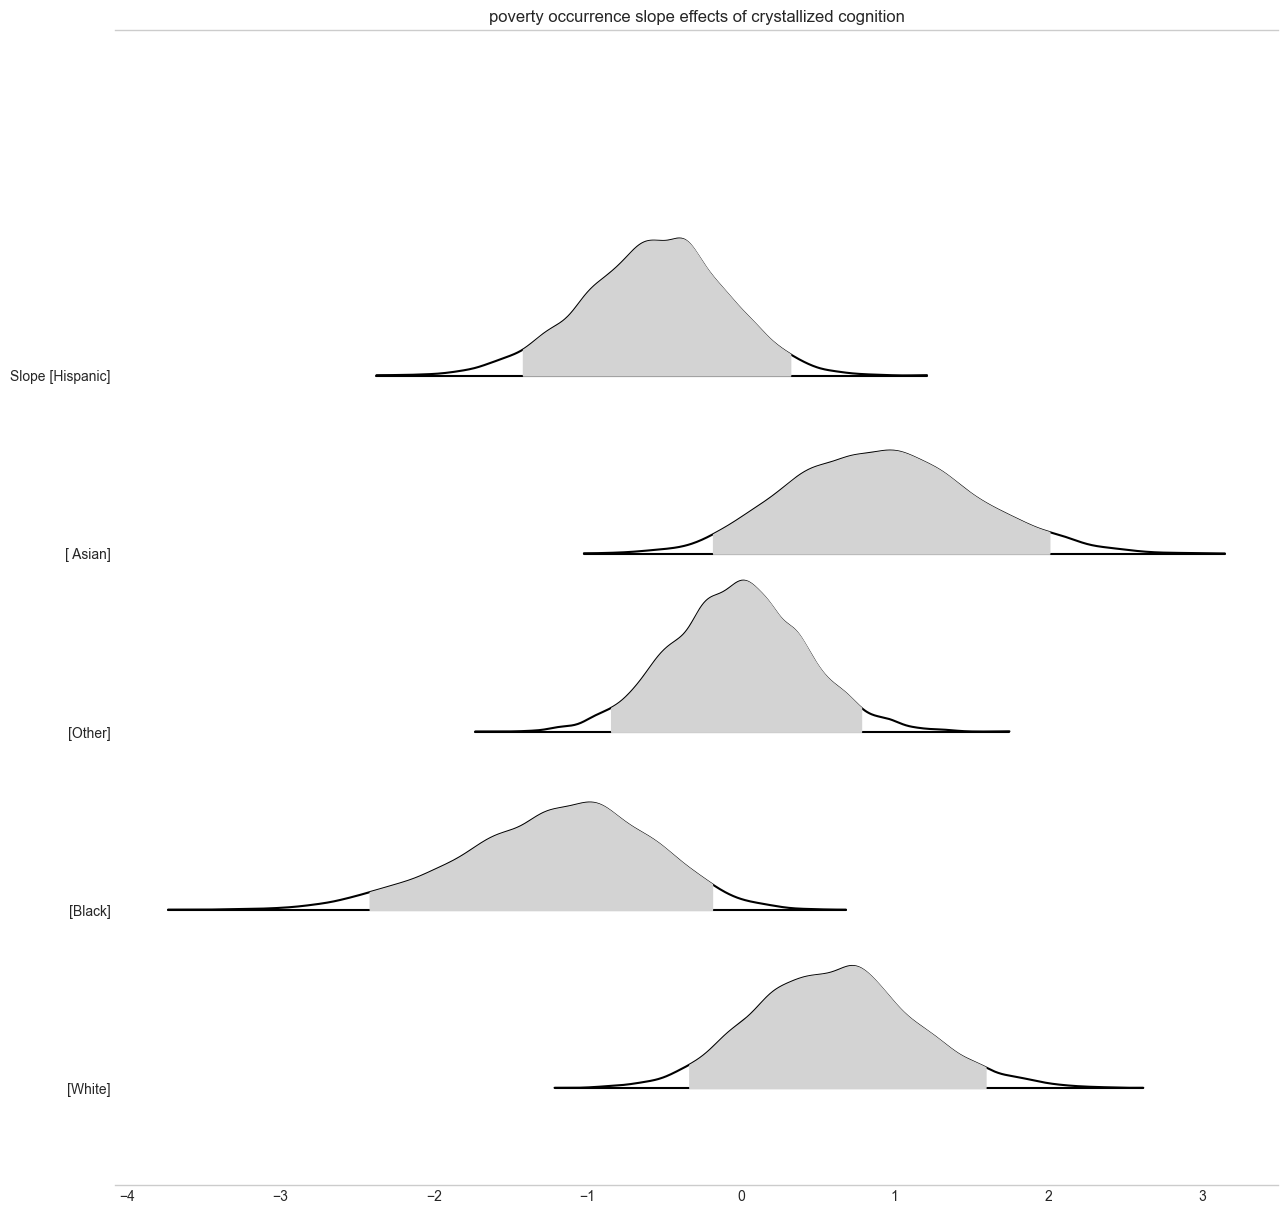

In [11]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("poverty occurrence slope effects of crystallized cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_ridge_plot_race_slope_pov_occur_crystallized_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [12]:
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [13]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.374913
r2_std    0.003592
dtype: float64

In [14]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [15]:
# get race, state and neighbourhood poverty occurrence columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_pov_df = pd.DataFrame(data['reshist_addr1_adi_pov_bin'],columns =['reshist_addr1_adi_pov_bin']).reset_index(drop=True)


In [16]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_pov_df,ppc_df,left_index=True, right_index=True)


In [17]:
ppc_pov_race_mean = (ppc_df.groupby(['reshist_addr1_adi_pov_bin','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_pov_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
reshist_addr1_adi_pov_bin race_ethnicity                                 
0.0                       Asian           0.282228  0.387873  0.267671   
                          Black           0.276444  0.159842  0.251341   
                          Hispanic        0.241453  0.249204  0.261248   
                          Other           0.277683  0.199500  0.235406   
                          White           0.307262  0.282019  0.272369   
1.0                       Asian           0.276772  0.416524  0.288673   
                          Black          -0.795864 -0.804292 -0.868995   
                          Hispanic       -0.406216 -0.458615 -0.492150   
                          Other          -0.147015 -0.220028 -0.266735   
                          White           0.153478  0.174661  0.160418   

                                          pp_cog_3  pp_cog_4  pp_cog_5  \
reshist_addr1_adi_pov_bin race_ethnicity                                 
0.0                       Asian           0.179273  0.234747  0.249960   
                          Black           0.269534  0.205720  0.257576   
                          Hispanic        0.219868  0.295621  0.234312   
                          Other           0.287810  0.225649  0.156325   
                          White           0.299226  0.301082  0.264192   
1.0                       Asian           0.403209  0.143638  0.126943   
                          Black          -0.809762 -0.851352 -0.886254   
                          Hispanic       -0.421233 -0.443648 -0.512025   
                          Other          -0.162335 -0.156107 -0.167112   
                          White           0.178441  0.209148  0.199364   

                                          pp_cog_6  pp_cog_7  pp_cog_8  \
reshist_addr1_adi_pov_bin race_ethnicity                                 
0.0                       Asian           0.252915  0.298711  0.347796   
                          Black           0.272183  0.272396  0.243231   
                          Hispanic        0.300818  0.212527  0.323778   
                          Other           0.238623  0.223042  0.277398   
                          White           0.275912  0.285138  0.300926   
1.0                       Asian           0.266029  0.306434  0.402881   
                          Black          -0.870157 -0.818439 -0.844082   
                          Hispanic       -0.474312 -0.498399 -0.452776   
                          Other          -0.251661 -0.297093 -0.124936   
                          White           0.155262  0.192336  0.141010   

                                          pp_cog_9  ...  pp_cog_7990  \
reshist_addr1_adi_pov_bin race_ethnicity            ...                
0.0                       Asian           0.340537  ...     0.270699   
                          Black           0.222097  ...     0.211081   
                          Hispanic        0.272648  ...     0.269903   
                          Other           0.209992  ...     0.226105   
                          White           0.271114  ...     0.306339   
1.0                       Asian           0.363480  ...     0.239652   
                          Black          -0.831929  ...    -0.821281   
                          Hispanic       -0.434569  ...    -0.492464   
                          Other          -0.195901  ...    -0.112507   
                          White           0.162495  ...     0.205090   

                                          pp_cog_7991  pp_cog_7992  \
reshist_addr1_adi_pov_bin race_ethnicity                             
0.0                       Asian              0.202552     0.342586   
                          Black              0.162366     0.189817   
                          Hispanic           0.308377     0.324767   
                          Other              0.190300     0.236358   
                          White              0.242698     0.281970   
1.0                 

In [18]:
ppc_pov_race_mean_summ=ppc_pov_race_mean.mean(axis=1)
ppc_pov_race_mean_summ

reshist_addr1_adi_pov_bin  race_ethnicity
0.0                        Asian             0.297487
                           Black             0.215956
                           Hispanic          0.271126
                           Other             0.253921
                           White             0.280385
1.0                        Asian             0.357607
                           Black            -0.847174
                           Hispanic         -0.455978
                           Other            -0.189076
                           White             0.167744
dtype: float64

In [19]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.280478,0.397061,0.274406,0.251084,0.205530,0.210512,0.257121,0.301188,0.365461,0.347894,...,0.260743,0.238591,0.406261,0.339996,0.404491,0.529138,0.446640,0.353174,0.290584,0.171742
Black,-0.583790,-0.613612,-0.647422,-0.596306,-0.642291,-0.660035,-0.644233,-0.602701,-0.629041,-0.623471,...,-0.617107,-0.672091,-0.653167,-0.657609,-0.619826,-0.651141,-0.634279,-0.653549,-0.604495,-0.713000
Hispanic,-0.216632,-0.251425,-0.271618,-0.233572,-0.227252,-0.293560,-0.247419,-0.290299,-0.225466,-0.227555,...,-0.269306,-0.234770,-0.270915,-0.210562,-0.235307,-0.264631,-0.236906,-0.241655,-0.234588,-0.222886
Other,0.067775,-0.007853,-0.012779,0.065324,0.036965,-0.003535,-0.003701,-0.034036,0.078543,0.009378,...,0.058745,0.006806,0.083429,0.051787,0.068467,0.018139,0.060360,-0.001529,0.045383,0.037578
White,0.253564,0.244532,0.233279,0.257050,0.268981,0.241556,0.233784,0.252734,0.245087,0.233187,...,0.270985,0.213690,0.244364,0.255807,0.255391,0.228478,0.230786,0.254659,0.224075,0.257057


In [20]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [21]:
ppc_pov_state_mean = (ppc_df.groupby(['reshist_addr1_adi_pov_bin','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_pov_state_mean_summ = ppc_pov_state_mean.mean(axis=1)


In [22]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [23]:
ppc_pov_state_mean_summ_list=ppc_pov_state_mean_summ.to_numpy()
low_pov_state = ppc_pov_state_mean_summ_list[:17]
high_pov_state = ppc_pov_state_mean_summ_list[-17:]

In [24]:
mean_predictions_state = [low_pov_state,high_pov_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.297845,0.258758,0.363261,0.229865,0.126003,0.242047,0.284453,0.081169,0.299228,0.119097,0.428061,0.208646,0.332752,0.287497,0.415405,0.217381,0.432673
1,-0.304469,-0.156424,-0.278538,-0.387886,-0.667007,-0.245637,-0.026917,-0.501211,-0.267039,-0.435657,0.124606,-0.523194,-0.299840,0.052221,0.234296,-0.354643,-0.034219


In [25]:
ppc_pov_race_mean_summ_list=ppc_pov_race_mean_summ.to_numpy()
low_pov_race = ppc_pov_race_mean_summ_list[:5]
high_pov_race = ppc_pov_race_mean_summ_list[-5:]

In [26]:
# initialize list of lists 
mean_predictions_race = [low_pov_race,high_pov_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,0.297487,0.215956,0.271126,0.253921,0.280385
1,0.357607,-0.847174,-0.455978,-0.189076,0.167744


In [27]:
#auxiliary data
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset.csv', usecols=['state','PovertyLT100_FPL_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [28]:
val = census_data['PovertyLT100_FPL_score'].median()
census_data.loc[census_data['PovertyLT100_FPL_score'] < val, 'PovertyLT100_FPL_score_bin'] = 0
census_data.loc[census_data['PovertyLT100_FPL_score'] >= val, 'PovertyLT100_FPL_score_bin'] = 1

In [29]:
census = (census_data.groupby(['state','race_ethnicity','PovertyLT100_FPL_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq
0,california,Asian,0.0,767423
1,california,Asian,1.0,1067892
2,california,Black,0.0,3168044
3,california,Black,1.0,786431
4,california,Hispanic,0.0,6779394
...,...,...,...,...
136,wisconsin,Black,1.0,39628
137,wisconsin,Hispanic,0.0,88054
138,wisconsin,Other,0.0,183517
139,wisconsin,White,0.0,4001207


In [30]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,767423,1,0
1,california,Asian,1.0,1067892,1,0
2,california,Black,0.0,3168044,3,0
3,california,Black,1.0,786431,3,0
4,california,Hispanic,0.0,6779394,0,0


In [31]:
#fix theano shared tensor type error
census=census.astype({'PovertyLT100_FPL_score_bin':'uint8'})

In [32]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_pov = census.PovertyLT100_FPL_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
pov_.set_value(ps_pov)

In [33]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [34]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(141, 8000)

In [35]:
censust=census
censust

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,race_enc,state_enc
0,california,Asian,0,767423,1,0
1,california,Asian,1,1067892,1,0
2,california,Black,0,3168044,3,0
3,california,Black,1,786431,3,0
4,california,Hispanic,0,6779394,0,0
...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,3,16
137,wisconsin,Hispanic,0,88054,0,16
138,wisconsin,Other,0,183517,2,16
139,wisconsin,White,0,4001207,4,16


In [36]:
# get race, state, and neighbourhood poverty occurrence  columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_pov_df2 = pd.DataFrame(censust['PovertyLT100_FPL_score_bin'],columns =['PovertyLT100_FPL_score_bin']).reset_index(drop=True)


In [37]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_pov_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-0.554607,1.480754,-0.494634,0.613454,-0.877780,-0.101373,...,1.005588,0.310128,0.575663,-0.272519,0.604939,-1.042625,-0.735519,0.990695,1.592239,0.065618
1,california,Asian,1,1067892,1.450551,0.468891,1.375569,-0.143691,0.614807,0.510115,...,-0.730903,-1.697572,-0.925355,0.725161,-0.501385,0.495951,1.607214,1.387457,-0.018368,0.672064
2,california,Black,0,3168044,-1.441206,-1.844419,-0.586770,0.824646,-0.503338,1.116133,...,1.379131,0.808450,0.184733,-0.629739,0.495474,-0.789114,0.986164,-0.217731,0.523671,0.824051
3,california,Black,1,786431,-0.498193,-1.125213,-1.243792,0.006065,-0.265978,0.069064,...,0.561396,0.248213,-0.377784,-1.012817,-2.010067,0.549205,-0.099300,-1.886082,-2.755411,-0.158313
4,california,Hispanic,0,6779394,1.221999,1.123656,-0.803746,0.100938,0.919683,0.442965,...,0.527177,0.010587,0.037694,1.237565,-0.815131,0.446932,1.999917,0.112091,0.382081,0.763408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,-2.434885,0.438703,0.532968,-0.103060,1.121484,1.251370,...,-1.612691,0.515078,0.173492,-1.030834,-2.360232,-0.664842,-0.003165,-1.232333,-2.930475,-0.195604
137,wisconsin,Hispanic,0,88054,-0.888853,0.788902,0.689583,0.555362,0.246871,-0.129168,...,0.976472,0.099773,-0.266016,-0.127478,2.558828,0.970396,-0.069499,0.269871,0.335378,0.111157
138,wisconsin,Other,0,183517,0.612286,0.027260,0.204318,-0.018308,0.773746,0.954781,...,0.579951,0.876896,0.608165,-0.263514,-0.400355,0.443923,0.048944,1.983721,-0.300161,-1.016729
139,wisconsin,White,0,4001207,-1.216750,1.327862,0.194679,0.825317,1.118527,0.994920,...,0.437867,-0.512275,-0.036284,0.494218,1.069788,1.459916,1.026490,0.380977,1.451507,1.318176


In [38]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','PovertyLT100_FPL_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -4.256182e+05   
                          1                          1    1.549032e+06   
           Black          0                          2   -4.565804e+06   
                          1                          3   -3.917947e+05   
           Hispanic       0                          4    8.284412e+06   
...                                                                ...   
wisconsin  Black          1                          136 -9.648963e+04   
           Hispanic       0                          137 -7.826707e+04   
           Other          0                          138  1.123649e+05   
           White          0                          139 -4.868468e+06   
                          1                          140  3.799943e+05   

                                                              pp_cog_1  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0    1.136365e+06   
                          1                          1    5.007249e+05   
           Black          0                          2   -5.843199e+06   
                          1                          3   -8.849027e+05   
           Hispanic       0                          4    7.617705e+06   
...                                                                ...   
wisconsin  Black          1                          136  1.738491e+04   
           Hispanic       0                          137  6.946594e+04   
           Other          0                          138  5.002741e+03   
           White          0                          139  5.313050e+06   
                          1                          140  1.460102e+05   

                                                              pp_cog_2  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -3.795937e+05   
                          1                          1    1.468959e+06   
           Black          0                          2   -1.858913e+06   
                          1                          3   -9.781566e+05   
           Hispanic       0                          4   -5.448909e+06   
...                                                                ...   
wisconsin  Black          1                          136  2.112045e+04   
           Hispanic       0                          137  6.072052e+04   
           Other          0                          138  3.749587e+04   
           White          0                          139  7.789530e+05   
                          1                          140  1.859555e+05   

                                                              pp_cog_3  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0    4.707789e+05   
                          1                          1   -1.534467e+05   
           Black          0                          2    2.612515e+06   
                          1                          3    4.769841e+03   
           Hispanic       0                          4    6.842956e+05   
...                                                                ...   
wisconsin  Black          1                          136 -4.084075e+03   
           Hispanic       0                          137  4.890186e+04   
           Other          0                          138 -3.359777e+03   
           White          0                          139  3.302264e+06   
                          1                          140 -6.445295e+04   

                                                              pp_cog_4  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -6.73

In [39]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-4.256182e+05,1.136365e+06,-3.795937e+05,4.707789e+05,-6.736287e+05,-7.779577e+04,1.783369e+05,8.903484e+05,9.900136e+05,5.425821e+04,...,7.717116e+05,2.379994e+05,441776.701534,-2.091373e+05,4.642443e+05,-8.001345e+05,-5.644543e+05,7.602819e+05,1.221921e+06,5.035699e+04
1,1.549032e+06,5.007249e+05,1.468959e+06,-1.534467e+05,6.565479e+05,5.447481e+05,1.159099e+06,6.402384e+05,1.985981e+06,1.352719e+06,...,-7.805250e+05,-1.812823e+06,-988179.356262,7.743932e+05,-5.354253e+05,5.296226e+05,1.716331e+06,1.481654e+06,-1.961506e+04,7.176913e+05
2,-4.565804e+06,-5.843199e+06,-1.858913e+06,2.612515e+06,-1.594597e+06,3.535957e+06,3.758476e+06,3.428969e+06,-1.667387e+06,1.001632e+06,...,4.369148e+06,2.561206e+06,585242.725572,-1.995041e+06,1.569682e+06,-2.499949e+06,3.124211e+06,-6.897811e+05,1.659013e+06,2.610630e+06
3,-3.917947e+05,-8.849027e+05,-9.781566e+05,4.769841e+03,-2.091737e+05,5.431432e+04,-1.554199e+06,-9.349430e+05,-1.013371e+06,-1.220530e+06,...,4.414994e+05,1.952022e+05,-297100.979807,-7.965109e+05,-1.580779e+06,4.319119e+05,-7.809277e+04,-1.483273e+06,-2.166940e+06,-1.245025e+05
4,8.284412e+06,7.617705e+06,-5.448909e+06,6.842956e+05,6.234894e+06,3.003036e+06,6.387220e+06,-2.622219e+06,9.137774e+06,2.763944e+05,...,3.573942e+06,7.177051e+04,255540.201590,8.389940e+06,-5.526093e+06,3.029928e+06,1.355822e+07,7.599087e+05,2.590276e+06,5.175443e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,-9.648963e+04,1.738491e+04,2.112045e+04,-4.084075e+03,4.444217e+04,4.958931e+04,-5.257018e+04,-1.252833e+04,-1.091766e+05,-5.434300e+04,...,-6.390773e+04,2.041150e+04,6875.139165,-4.084989e+04,-9.353126e+04,-2.634637e+04,-1.254028e+02,-4.883489e+04,-1.161288e+05,-7.751382e+03
137,-7.826707e+04,6.946594e+04,6.072052e+04,4.890186e+04,2.173798e+04,-1.137378e+04,6.033240e+04,1.246389e+05,3.116800e+04,1.620926e+05,...,8.598230e+04,8.785430e+03,-23423.796854,-1.122492e+04,2.253151e+05,8.544722e+04,-6.119705e+03,2.376320e+04,2.953140e+04,9.787809e+03
138,1.123649e+05,5.002741e+03,3.749587e+04,-3.359777e+03,1.419955e+05,1.752186e+05,2.442801e+05,9.586672e+04,-1.490290e+05,3.422213e+05,...,1.064309e+05,1.609253e+05,111608.657888,-4.835927e+04,-7.347190e+04,8.146744e+04,8.981980e+03,3.640464e+05,-5.508455e+04,-1.865871e+05
139,-4.868468e+06,5.313050e+06,7.789530e+05,3.302264e+06,4.475460e+06,3.980881e+06,4.653438e+06,8.809830e+05,1.741348e+06,3.009690e+06,...,1.751996e+06,-2.049719e+06,-145179.494004,1.977469e+06,4.280444e+06,5.841425e+06,4.107198e+06,1.524366e+06,5.807779e+06,5.274295e+06


In [40]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq
0,california,Asian,0,767423
1,california,Asian,1,1067892
2,california,Black,0,3168044
3,california,Black,1,786431
4,california,Hispanic,0,6779394
...,...,...,...,...
136,wisconsin,Black,1,39628
137,wisconsin,Hispanic,0,88054
138,wisconsin,Other,0,183517
139,wisconsin,White,0,4001207


In [41]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-4.256182e+05,1.136365e+06,-3.795937e+05,4.707789e+05,-6.736287e+05,-7.779577e+04,...,7.717116e+05,2.379994e+05,441776.701534,-2.091373e+05,4.642443e+05,-8.001345e+05,-5.644543e+05,7.602819e+05,1.221921e+06,5.035699e+04
1,california,Asian,1,1067892,1.549032e+06,5.007249e+05,1.468959e+06,-1.534467e+05,6.565479e+05,5.447481e+05,...,-7.805250e+05,-1.812823e+06,-988179.356262,7.743932e+05,-5.354253e+05,5.296226e+05,1.716331e+06,1.481654e+06,-1.961506e+04,7.176913e+05
2,california,Black,0,3168044,-4.565804e+06,-5.843199e+06,-1.858913e+06,2.612515e+06,-1.594597e+06,3.535957e+06,...,4.369148e+06,2.561206e+06,585242.725572,-1.995041e+06,1.569682e+06,-2.499949e+06,3.124211e+06,-6.897811e+05,1.659013e+06,2.610630e+06
3,california,Black,1,786431,-3.917947e+05,-8.849027e+05,-9.781566e+05,4.769841e+03,-2.091737e+05,5.431432e+04,...,4.414994e+05,1.952022e+05,-297100.979807,-7.965109e+05,-1.580779e+06,4.319119e+05,-7.809277e+04,-1.483273e+06,-2.166940e+06,-1.245025e+05
4,california,Hispanic,0,6779394,8.284412e+06,7.617705e+06,-5.448909e+06,6.842956e+05,6.234894e+06,3.003036e+06,...,3.573942e+06,7.177051e+04,255540.201590,8.389940e+06,-5.526093e+06,3.029928e+06,1.355822e+07,7.599087e+05,2.590276e+06,5.175443e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,-9.648963e+04,1.738491e+04,2.112045e+04,-4.084075e+03,4.444217e+04,4.958931e+04,...,-6.390773e+04,2.041150e+04,6875.139165,-4.084989e+04,-9.353126e+04,-2.634637e+04,-1.254028e+02,-4.883489e+04,-1.161288e+05,-7.751382e+03
137,wisconsin,Hispanic,0,88054,-7.826707e+04,6.946594e+04,6.072052e+04,4.890186e+04,2.173798e+04,-1.137378e+04,...,8.598230e+04,8.785430e+03,-23423.796854,-1.122492e+04,2.253151e+05,8.544722e+04,-6.119705e+03,2.376320e+04,2.953140e+04,9.787809e+03
138,wisconsin,Other,0,183517,1.123649e+05,5.002741e+03,3.749587e+04,-3.359777e+03,1.419955e+05,1.752186e+05,...,1.064309e+05,1.609253e+05,111608.657888,-4.835927e+04,-7.347190e+04,8.146744e+04,8.981980e+03,3.640464e+05,-5.508455e+04,-1.865871e+05
139,wisconsin,White,0,4001207,-4.868468e+06,5.313050e+06,7.789530e+05,3.302264e+06,4.475460e+06,3.980881e+06,...,1.751996e+06,-2.049719e+06,-145179.494004,1.977469e+06,4.280444e+06,5.841425e+06,4.107198e+06,1.524366e+06,5.807779e+06,5.274295e+06


In [42]:
#final step of poststratification - by race & poverty occurrence 
#data-weighted average
ppc_pov_race_poststrat = ppc_poststrat_df.groupby(['PovertyLT100_FPL_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_pov_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.589288  0.433826  0.129696   
                           Black          -0.102904 -0.043515  0.308899   
                           Hispanic        0.955557  1.140935 -0.142794   
                           Other           1.045108  0.576028  0.423481   
                           White          -0.030933  0.994966 -0.577679   
1                          Asian           0.714803 -0.157122  0.978841   
                           Black          -0.500175 -0.569699 -1.172535   
                           Hispanic        0.435235 -0.921626 -0.167984   
                           Other          -0.990727  0.519597 -0.281458   
                           White           0.145976  0.220332  0.202828   

                                           pp_cog_3  pp_cog_4  pp_cog_5  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.138576 -0.326924  0.684159   
                           Black           0.431685  0.234474  0.610550   
                           Hispanic       -0.059074  0.250975  0.320412   
                           Other          -0.142636  0.049972 -0.611381   
                           White           0.559865 -0.053058  0.617006   
1                          Asian           0.116217  0.437132  0.241914   
                           Black          -0.611599 -0.811401 -1.189705   
                           Hispanic       -0.800690 -0.090213 -0.771243   
                           Other           0.231548  0.119253 -0.001673   
                           White           0.601314  0.629847  0.091905   

                                           pp_cog_6  pp_cog_7  pp_cog_8  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           1.061255 -0.007105 -0.201435   
                           Black           0.485894  0.253704  0.386303   
                           Hispanic        0.505975 -0.200605  0.612043   
                           Other           1.373429  0.669302 -0.129897   
                           White           0.354305  0.522594 -0.022318   
1                          Asian           0.744656  0.676047  0.590823   
                           Black          -0.971174 -0.615029 -1.042243   
                           Hispanic       -0.619901 -0.709105 -0.874549   
                           Other          -0.348733 -1.794760  0.148619   
                           White           0.315733  0.318112 -0.050082   

                                           pp_cog_9  ...  pp_cog_7990  \
PovertyLT100_FPL_score_bin race_ethnicity            ...                
0                          Asian           0.702082  ...     0.107315   
                           Black           0.468592  ...     0.406917   
                           Hispanic        0.201584  ...     0.367482   
                           Other           0.570424  ...    -0.244989   
                           White          -0.090453  ...     0.706330   
1                          Asian           0.612675  ...     0.551785   
                           Black          -0.806066  ...    -0.558489   
                           Hispanic       -0.052810  ...    -1.253927   
                           Other           0.149218  ...    -0.425254   
                           White           0.160439  ...    -0.420085   

                                           pp_cog_7991  pp_cog_7992  \
PovertyLT100_FPL_score_bin race_ethnicity                             
0                          Asian              0.136556     0.316416   
                           Black              0.010662     0.193245   
                           Hispanic           0.234669     0.221924   
                           Other              0.896813     0.221547   
                           White     

In [43]:
#summarize race & poverty occurrence poststrat results
ppc_pov_race_poststrat_summ = ppc_pov_race_poststrat.mean(axis=1)
ppc_pov_race_poststrat_summ

PovertyLT100_FPL_score_bin  race_ethnicity
0                           Asian             0.251217
                            Black             0.233496
                            Hispanic          0.268835
                            Other             0.264093
                            White             0.286602
1                           Asian             0.356632
                            Black            -0.812405
                            Hispanic         -0.461377
                            Other            -0.180856
                            White             0.154837
dtype: float64

In [44]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian       0.277936
Black      -0.017825
Hispanic   -0.106500
Other      -0.005164
White       0.219734
dtype: float64

In [45]:
#for the lollipops
#final step poststrat - by state & neighbourhood poverty occurrence
ppc_pov_state_poststrat = ppc_poststrat_df.groupby(['PovertyLT100_FPL_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_pov_state_poststrat_summ = ppc_pov_state_poststrat.mean(axis=1)
ppc_pov_state_poststrat_summ

PovertyLT100_FPL_score_bin  state        
0                           california       0.306333
                            colorado         0.251166
                            connecticut      0.366371
                            florida          0.230632
                            maryland         0.119722
                            michigan         0.237608
                            minnesota        0.286070
                            missouri         0.078646
                            newyork          0.297701
                            oklahoma         0.113038
                            oregon           0.426963
                            pennsylvania     0.211784
                            southcarolina    0.327946
                            utah             0.301295
                            vermont          0.422347
                            virginia         0.228032
                            wisconsin        0.436968
1                           california  

In [46]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california       0.163651
colorado         0.192596
connecticut      0.366371
florida         -0.065447
maryland        -0.026076
michigan         0.147680
minnesota        0.250303
missouri        -0.082677
newyork          0.063296
oklahoma        -0.078006
oregon           0.290375
pennsylvania     0.160022
southcarolina    0.058380
utah             0.257191
vermont          0.408154
virginia         0.140598
wisconsin        0.435109
dtype: float64

In [47]:
ppc_pov_state_poststrat_summ_list=ppc_pov_state_poststrat_summ.tolist()

In [48]:
#fill in missing value for connecticut
ppc_pov_state_poststrat_summ_list.insert(19,ppc_pov_state_mean_summ.iloc[19])

In [49]:
ppc_pov_state_poststrat_summ_list

[0.306333000360028,
 0.2511662867243663,
 0.36637077743370255,
 0.23063218233569083,
 0.11972224086908129,
 0.23760814656010212,
 0.28607012296753936,
 0.07864631827769869,
 0.2977007227778879,
 0.11303770582583376,
 0.4269632616916674,
 0.21178389582833346,
 0.327946070747516,
 0.30129473820950575,
 0.42234721527530517,
 0.2280317324304495,
 0.4369681026539169,
 0.055046594954964743,
 -0.2692308572723428,
 -0.2785382478479679,
 -0.34025476572027946,
 -0.8844003887094221,
 0.06528529980509176,
 0.09570171065483771,
 -0.21148564275767504,
 -0.13920576166365628,
 -0.12879078935444035,
 0.20503384940250874,
 0.03515695840541938,
 -0.07033266546158544,
 -0.1710942402702695,
 0.3031550916372232,
 -0.07007569728342036,
 0.4283434959524757]

In [50]:
low_pov_state_poststrat = ppc_pov_state_poststrat_summ_list[:17]
high_pov_state_poststrat = ppc_pov_state_poststrat_summ_list[-17:]

In [51]:
ppc_pov_race_poststrat_summ_list=ppc_pov_race_poststrat_summ.tolist()

In [52]:
low_pov_race_poststrat = ppc_pov_race_poststrat_summ_list[:5]
high_pov_race_poststrat = ppc_pov_race_poststrat_summ_list[-5:]

In [53]:
mean_predictions_state_ps = [low_pov_state_poststrat,high_pov_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.306333,0.251166,0.366371,0.230632,0.119722,0.237608,0.286070,0.078646,0.297701,0.113038,0.426963,0.211784,0.327946,0.301295,0.422347,0.228032,0.436968
1,0.055047,-0.269231,-0.278538,-0.340255,-0.884400,0.065285,0.095702,-0.211486,-0.139206,-0.128791,0.205034,0.035157,-0.070333,-0.171094,0.303155,-0.070076,0.428343


In [54]:
# initialize list of lists 
mean_predictions_race_ps = [low_pov_race_poststrat,high_pov_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,0.251217,0.233496,0.268835,0.264093,0.286602
1,0.356632,-0.812405,-0.461377,-0.180856,0.154837


In [55]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

quantiles_state,quantiles_state_ps

([-0.04785635049605523,
  0.13043423682469762,
  0.116905843498115,
  -0.23435163318471114,
  -0.2244351363461291,
  0.0024677611900656383,
  0.20651530176967398,
  -0.20098607324636109,
  0.013466867706912456,
  -0.1709706977398869,
  0.2605123349040546,
  -0.3914815699373957,
  0.032133545638087735,
  0.17802784934372312,
  0.35469947185178885,
  -0.055676074938930536,
  0.29651498435727874],
 [0.16574312999587668,
  0.19006995791153625,
  0.36237878070513185,
  -0.0682113895049816,
  -0.02757520818324779,
  0.14727473953952677,
  0.24632641967115318,
  -0.08467138099721103,
  0.06041701561764046,
  -0.08048450615692371,
  0.28298402430558706,
  0.16491354225734778,
  0.06602670663862903,
  0.2605250628580762,
  0.4109511065555078,
  0.13331717097491508,
  0.4356969266679216])

In [56]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

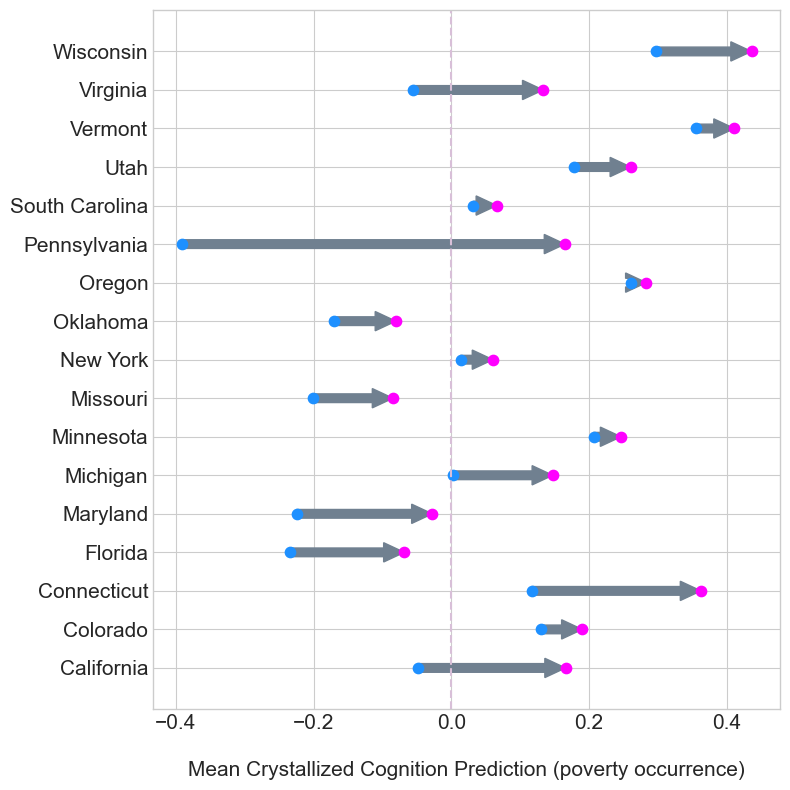

In [57]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Crystallized Cognition Prediction (poverty occurrence)',size=15,labelpad=20)
#plt.title('Mean Predictions of Crystallized Cognition based on Poverty Occurrence Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_pov_occur_crystallized_ps_state_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [58]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

quantiles_race,quantiles_race_ps

([0.3159507884060944,
  -0.6368925406697794,
  -0.24317059497144006,
  0.0346531139813787,
  0.24098014969519138],
 [0.27483657565624464,
  -0.021183835369961324,
  -0.10654313737679708,
  -0.003691517098973093,
  0.21934513841798187])

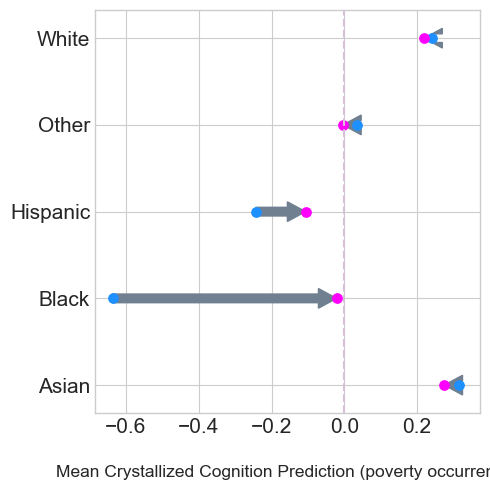

In [59]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Crystallized Cognition Prediction (poverty occurrence)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of Crystallized Cognition based on Poverty Occurrence Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_pov_occur_crystallized_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63048/3993079840.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63048/3993079840.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


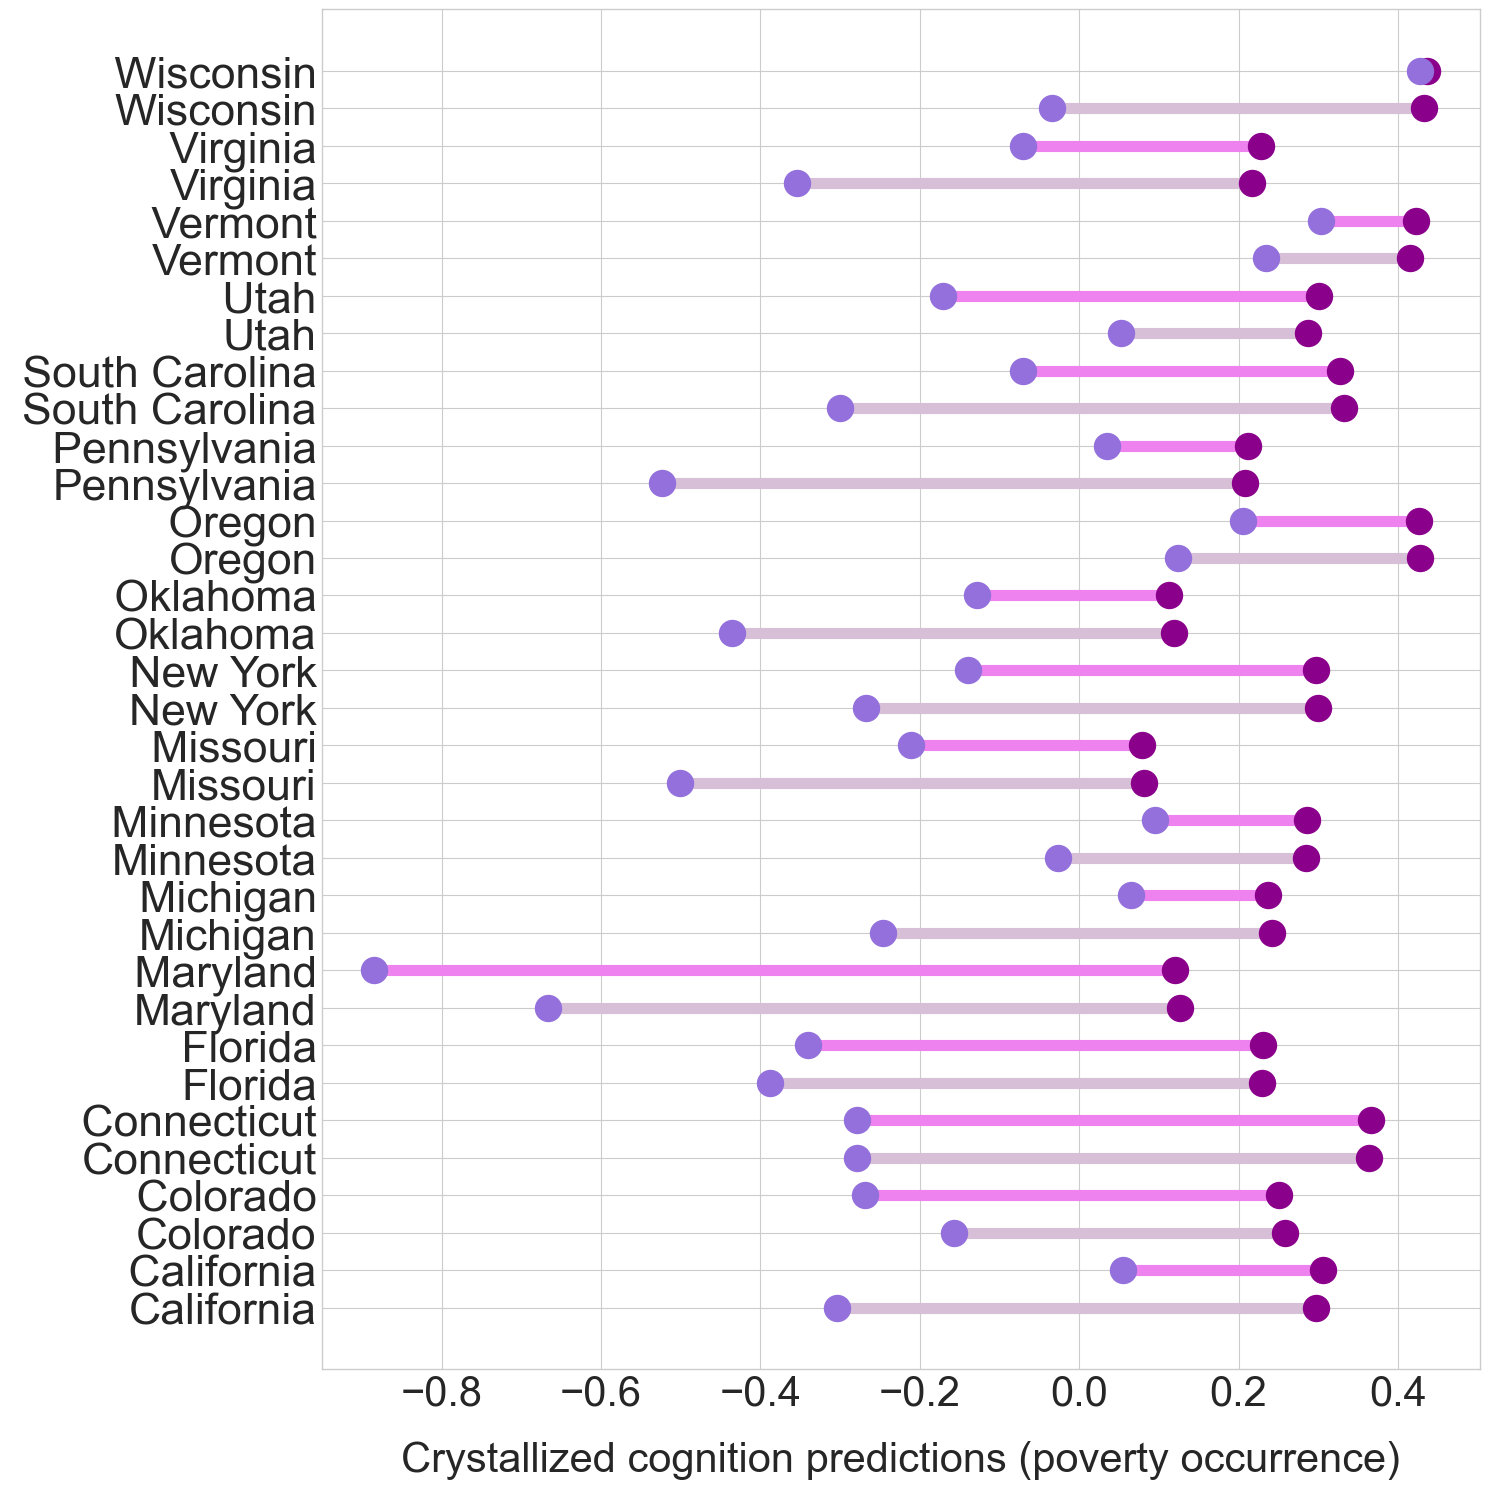

In [60]:
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='darkmagenta', label='low pov oc', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='mediumpurple', label='high pov oc', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='darkmagenta', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='mediumpurple', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Crystallized cognition predictions (poverty occurrence)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','low pov oc', 'high pov oc'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_pov_occur_crystallized_ps_state_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63048/540439372.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63048/540439372.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


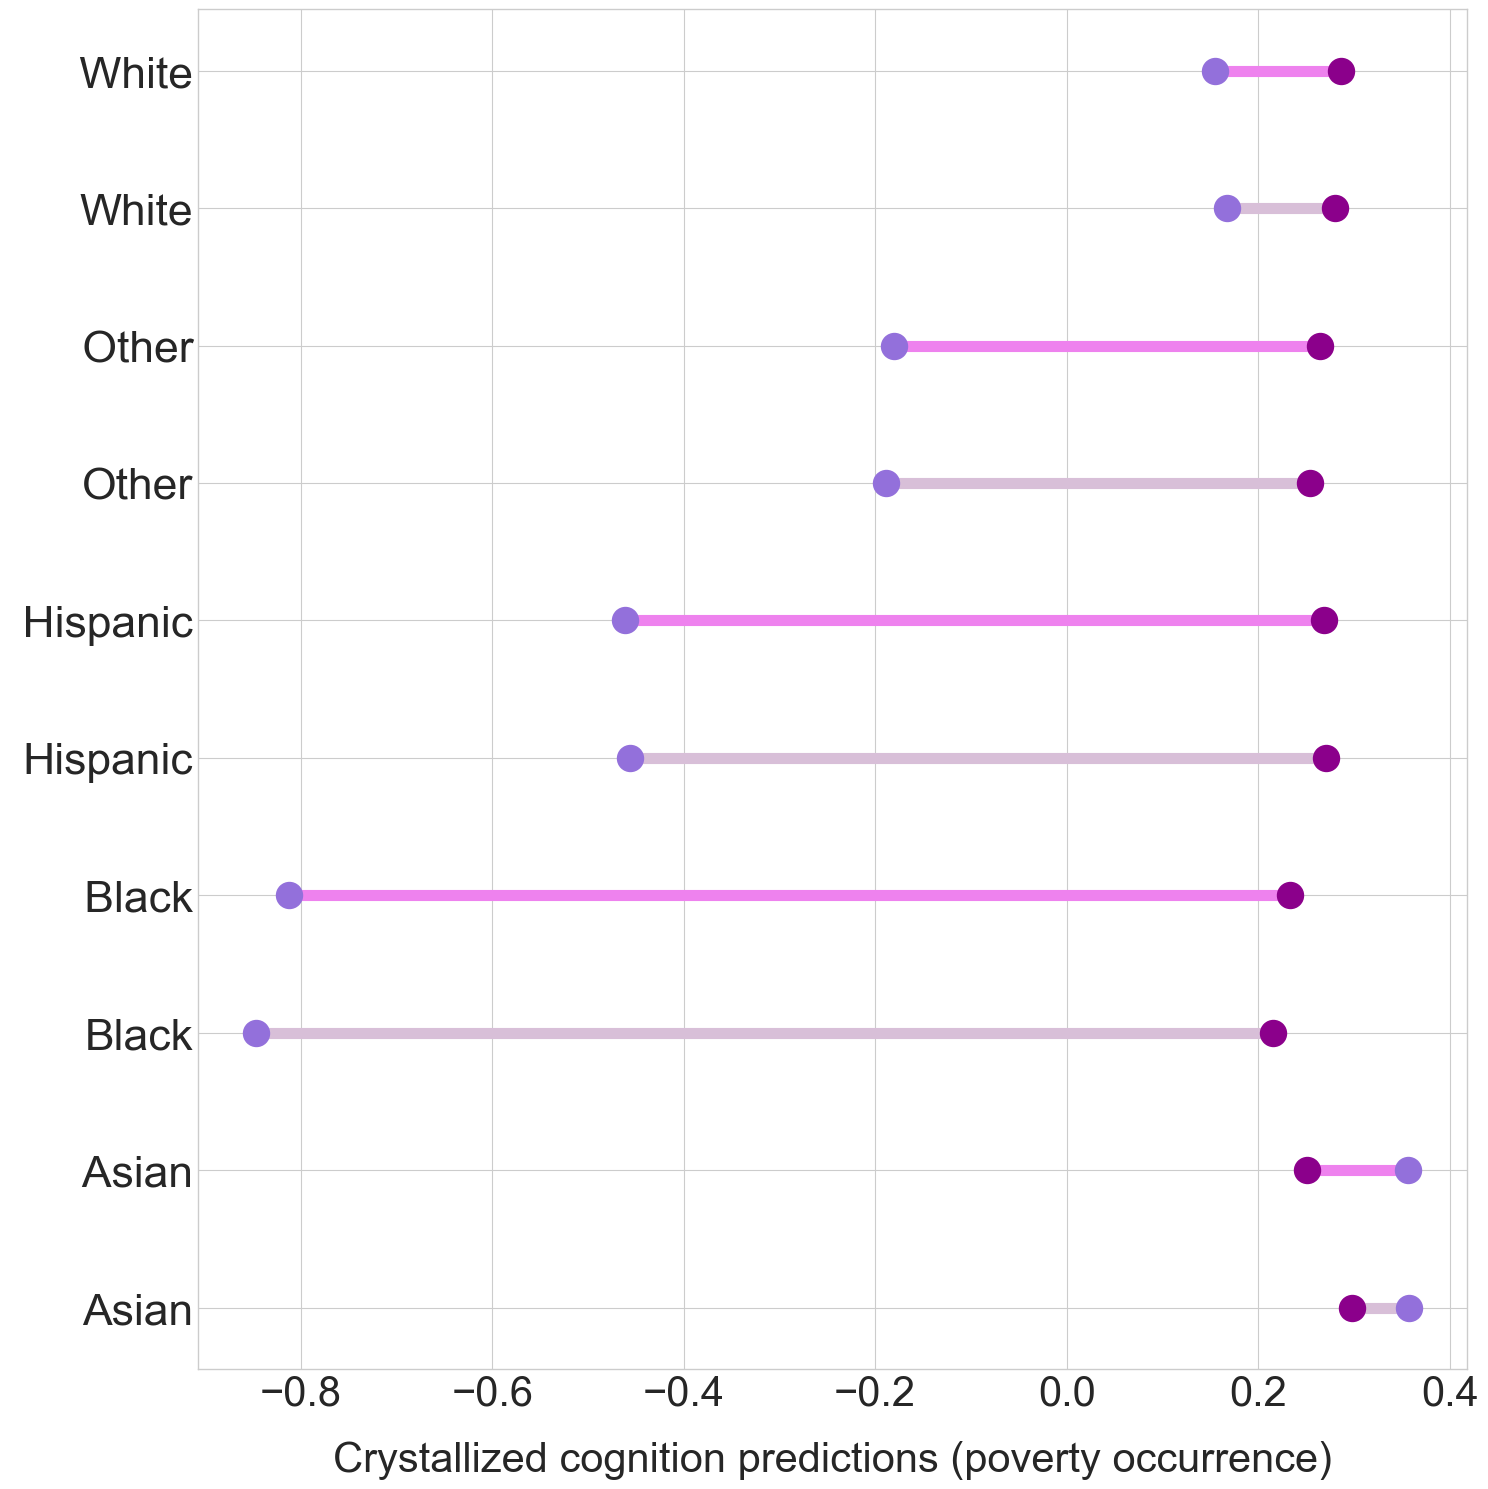

In [61]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='darkmagenta', label='low pov oc', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='mediumpurple', label='high pov oc', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='darkmagenta', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='mediumpurple', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Crystallized cognition predictions (poverty occurrence)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','low pov oc', 'high pov oc'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_pov_occur_crystallized_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()